In [1]:
#Load the required libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Model,load_model
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
import re
import json
import seaborn as sns

from IPython.display import display, HTML
from pdb import set_trace

%matplotlib inline
sns.set()

In [2]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('dicts/partition_MSI.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('dicts/MSILabels.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['full'] = partition['train']

In [3]:
#Define the Data Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=6030, dim=(226,211), #n_channels=1,
                 n_classes=20, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*6030:(index+1)*6030] #7900 become 800 for the val data
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        #check shape
        #print('X : shape = %s, type = %s' % (X.shape, X.dtype) ) # If np.array
        #print('y : shape = %s, type = %s' % (y.shape, y.dtype) )

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, 226)) #226 is the max len here
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/PATH/Cochs/' + ID + '.npy') #Path to word cochleagrams

            # Store class
            y[i] = self.labels[ID]
        
        self.my_labels = y
       
        return X, y#keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
# Parameters for the Data Generator
params = {'dim': (226,211),
          'batch_size': 6030,
          'n_classes': 20,
          #'n_channels': 1,
          'shuffle': False}

# Datasets
partition = partition
labels = labels

# Generators
full_generator = DataGenerator(partition['full'], labels, **params)

In [5]:
#Load the model and chose the penultimate layer
import tensorflow as tf

model = tf.keras.models.load_model('/bestdorsalmodel.hd5f')
#model.summary()
interim_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('lstm').output)
interim_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, 226, 211)]        0         
_________________________________________________________________
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
Total params: 1,482,752
Trainable params: 1,482,752
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Get the features from the model for the test data
hiddenacts = interim_model.predict(full_generator, verbose=0)
hiddenacts = hiddenacts[:,:,:]
print(hiddenacts.shape)

(6030, 226, 512)


In [7]:
with open('dicts/Morphemes.txt') as my_file:
    Morphemes = my_file.read().splitlines() 
    Morphemes = np.array(Morphemes)    
print(Morphemes)

['-LY (adj. to adv.)' '-LY (adj. to adv.)' '-LY (adj. to adv.)' ...
 'MIS- (v. to n.)' 'MIS- (v. to n.)' 'MIS- (v. to n.)']


In [8]:
morph_dict = {morph: [] for morph in Morphemes}


for i in range(6030):
    morph_dict[Morphemes[i]].append(hiddenacts[i])


for morph in morph_dict.keys():
    morph_dict[morph] = np.mean(np.array(morph_dict[morph]), 0)


#print(morph_dict)

In [10]:
#creating the 40 by 512 matrix from the word_dict where we get avg hidden unit activations from t0 to t226
Morphz = np.unique(Morphemes)
unit_dict = {}
activations = []

for m in Morphz:
    unit_dict["%s" %m] = (morph_dict[m]) # extract each word's 226X512 array from morph_dict
    unit_dict["%s" %m] = unit_dict["%s" %m].mean(axis=0) #getting the mean of hiddeen unit activations from t0 to t 226 (each column).
    #print(unit_dict[p].shape)
    activations = np.concatenate([activations, unit_dict["%s" %m]])
activations = np.reshape(activations, (20, 512)) 
print(activations.shape)    

(20, 512)


# Calculating the MSI from Activations of 39X512

In [12]:
#Word(i) hidden unit (j) pair P(ij) received 1 point for every word to which hidden unit j responded 
#more weakly than it did to word i by a threshold (0.15).

sample = activations.T #our logic works on rows so we transpose the activations matrix
#print(sample.shape)

MSI = []
k = 0
threshold = 0.3 # 0.3 from EARSHOT paper

for i in range(sample.shape[0]):# row
    for j in range(sample.shape[1]): # column
        for n in range(sample.shape[1]): # row
            #print(n)
            if (abs(sample[i,j] - sample[i,n]) >= threshold) & (sample[i,j] > sample[i,n]) :
                k = k + 1
        MSI.append(k)
        k = 0
        
MSI= np.array(MSI)        
MSI = MSI.reshape(512,20)
MSI = MSI.T # we transpose it again so we have the orijinal matrix of 39 phonemes and 512 hidden units
print(MSI.shape)
np.set_printoptions(suppress=True)
#np.savetxt('PSI.csv', WSI, delimiter=',')

(20, 512)


In [13]:
#finding zero arrays and delete them
idx = np.argwhere(np.all(MSI[..., :] == 0, axis=0))
idx.size # figure out how many columns are zero

MSI_Uniq = np.delete(MSI, idx, axis=1)
print(MSI_Uniq.shape)

(20, 433)


In [14]:
# #heatmap of activations
# fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches

# #x_axis_labels = np.arange(0,,5)
# y_axis_labels = Phonemes # labels for y-axis
# cmap = sns.color_palette("vlag", as_cmap=True)
# ax = sns.heatmap(PSI_Uniq, yticklabels=y_axis_labels, #xticklabels=x_axis_labels, linewidth=0.5,
#                   cmap=cmap)
# ax.set(xlabel='Hidden Units', ylabel='Phonemes')
# #fig.savefig('Activations.png',dpi=300)

In [15]:
Morphz

array(['-ABLE (v. to adj.)', '-AL (v. to n.)', '-ED (v. to v.)',
       '-ER (adj. to adj.)', '-ER (v. to n.)', '-FUL (n. to adj.)',
       '-ING (v. to v.)', '-ION (v. to n.)', '-LY (adj. to adv.)',
       '-LY (n. to adj.)', '-MENT (v. to n.)', '-NESS (adj. to n.)',
       '-S (n. to n.)', '-S (v. to v.)', '-Y (n. to adj.)',
       'EN- (adj.,v. to v.)', 'MIS- (v. to n.)', 'PRE- (adj.,v. to adj.)',
       'RE- (v. to v.)', 'UN- (adj. to adj.)'], dtype='<U22')

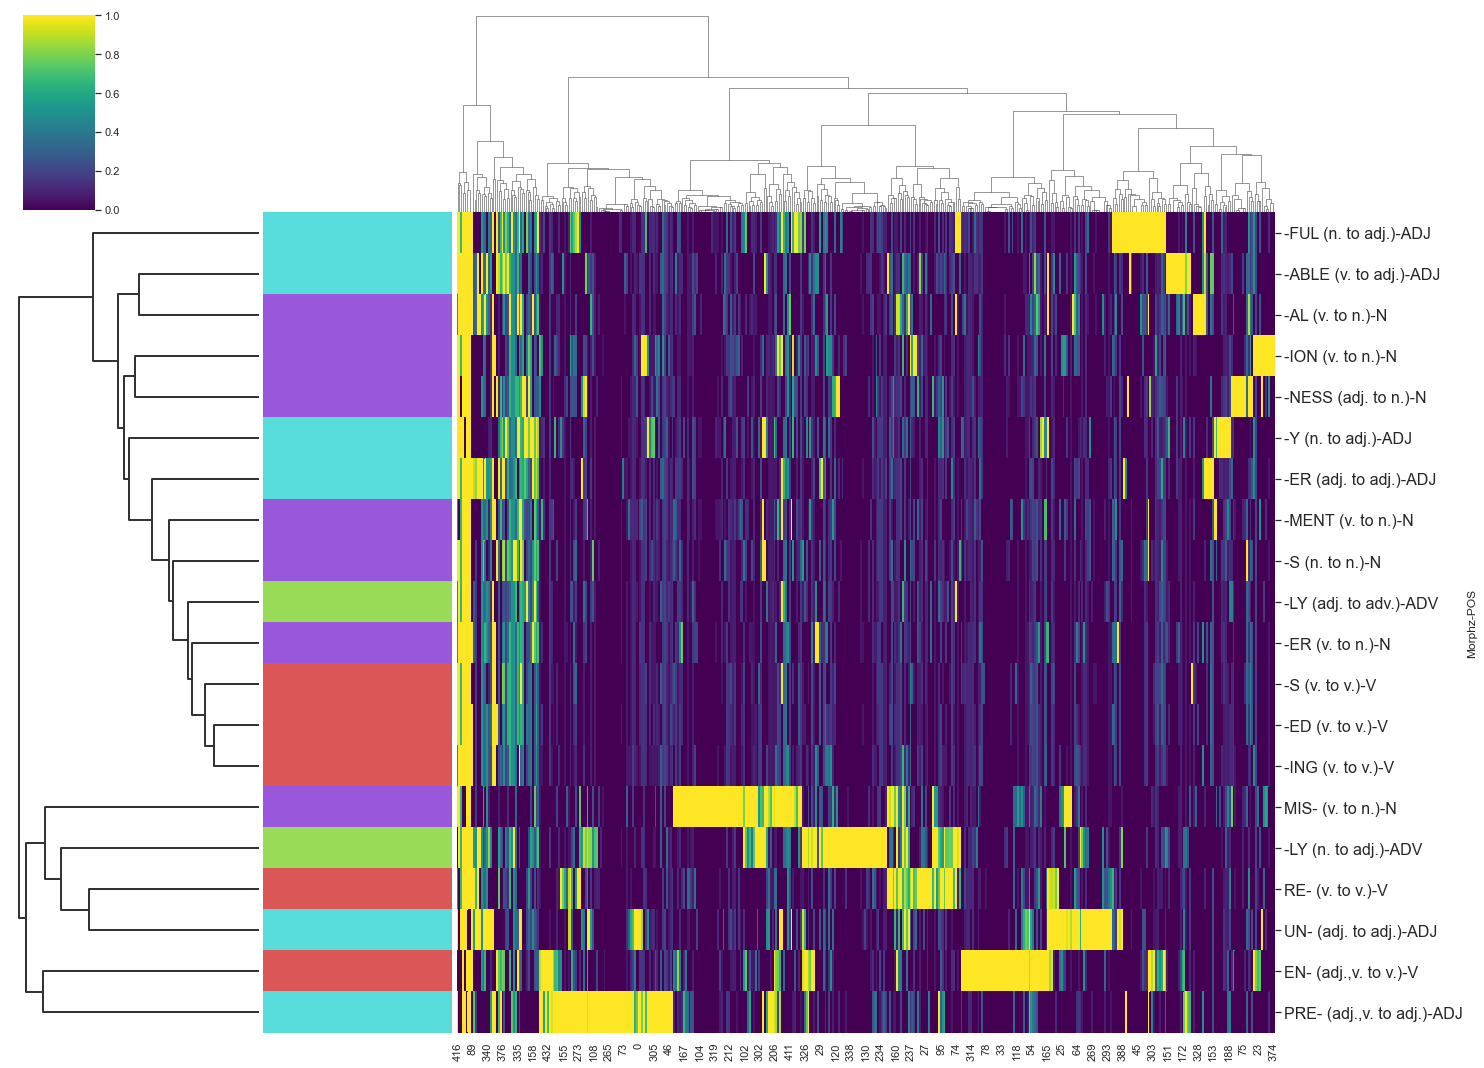

In [20]:
#cluster heatmap
import seaborn as sns; sns.set_theme(color_codes=True)
from matplotlib import pyplot as plt

#put the array into df
data = pd.DataFrame(MSI_Uniq)
data['Morphz'] = Morphz
data['POS'] = ['ADJ', 'N', 'V', 'ADJ', 'N',
               'ADJ', 'V', 'N', 'ADV', 'ADV',
               'N', 'N', 'N', 'V', 'ADJ',
               'V', 'N', 'ADJ', 'V', 'ADJ']
data = data.set_index(['Morphz', 'POS'])
#data.head

POS = data.index.get_level_values("POS")

# Prepare a vector of color mapped to the 'cyl' column
my_palette = dict(zip(POS.unique(), sns.hls_palette(4, h=.5)))
row_colors = POS.map(my_palette)

# linkage method to use for calculating clusters: ward

fig = sns.clustermap(data, figsize=(20, 15), metric="euclidean", standard_scale=1, row_colors=row_colors,
                     method="ward", cmap="viridis",  colors_ratio=0.15)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
for a in fig.ax_row_dendrogram.collections:
    a.set_linewidth(2)
#fig.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
plt.savefig('MSI_dorsal_1.png',dpi=300)
plt.show()